# Model devepment

In this document we develop and compare different models for our model devepment. We have the following sections:

1. Model creation
2. Model evaluation
3. Model implementation on test data

Note that for model creation instead of running the code each time one can load the best model.



### Import libraries

In [2]:
from preprocessing import preprocessor
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, roc_auc_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import uniform, randint
import joblib


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


### Data collection

In [ ]:
# Load the dataset
total_df = pd.read_csv('../Data/Base.csv')

# Define features (X) and target (y)
X = total_df.drop(columns=['fraud_bool'])
y = total_df['fraud_bool']

# Split the data into training and test sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Data has been loaded")

# Apply the preprocessor to the training and test datasets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


Data has been loaded


## 1. Model Creation

### 1a. Hyperparameter specification

We will use the following hyperparameters for our models. They are based on common hyperparameters used for the respective models with ranges that are commonly used.

In [21]:
# Pipeline with placeholder classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])

# Define models and hyperparameters
models = {
    'Logistic Regression (lbfgs)': (
        LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
        {
            'classifier__C': uniform(0.01, 10),  # Regularization strength
            'classifier__solver': ['lbfgs'],  # Only lbfgs solver
            'classifier__penalty': ['l2', 'none'],  # Supported penalties
        }
    ),
    # 'Logistic Regression (liblinear)': (
    #     LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    #     {
    #         'classifier__C': uniform(0.01, 10),  # Regularization strength
    #         'classifier__solver': ['liblinear'],  # Only liblinear solver
    #         'classifier__penalty': ['l1', 'l2'],  # Supported penalties
    #     }
    # ),
    # 'Logistic Regression (saga)': (
    #     LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    #     {
    #         'classifier__C': uniform(0.01, 10),  # Regularization strength
    #         'classifier__solver': ['saga'],  # Only saga solver
    #         'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # All supported penalties
    #         'classifier__l1_ratio': uniform(0, 1),  # ElasticNet mixing parameter (only with saga and elasticnet)
    #     }
    # ),
    # 'Logistic Regression (default)': (
    #     LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    #     {
    #         'classifier__C': uniform(0.01, 10),  # Regularization strength
    #     }
    # ),
    # 'Random Forest': (
    #     RandomForestClassifier(class_weight='balanced', random_state=42),
    #     {
    #         'classifier__n_estimators': randint(100, 300),  # Number of trees
    #         'classifier__max_depth': randint(5, 20),  # Max tree depth
    #         'classifier__min_samples_split': randint(2, 10),  # Min samples to split
    #         'classifier__min_samples_leaf': randint(1, 5),  # Min samples per leaf
    #         'classifier__class_weight': ['balanced', {0: 1, 1: 10}],  # Explicit weights
    #     }
    # ),
    # 'Gradient Boosting': (
    #     GradientBoostingClassifier(random_state=42),
    #     {
    #         'classifier__n_estimators': randint(50, 300),  # Number of boosting stages
    #         'classifier__learning_rate': uniform(0.01, 0.2),  # Shrinkage rate
    #         'classifier__max_depth': randint(3, 15),  # Max tree depth
    #         'classifier__min_samples_split': randint(2, 10),  # Min samples to split
    #         'classifier__min_samples_leaf': randint(1, 5),  # Min samples per leaf
    #     }
    # ),
    'XGBoost': (
        XGBClassifier(random_state=42, eval_metric='logloss', device='cuda', tree_method='hist'),
        {
            'classifier__n_estimators': randint(50, 300),  # Number of boosting stages
            'classifier__learning_rate': uniform(0.01, 0.2),  # Learning rate
            'classifier__max_depth': randint(3, 15),  # Maximum tree depth
            'classifier__gamma': uniform(0, 0.5),  # Min split loss
            'classifier__scale_pos_weight': [1, 5, 10, 20],  # Reweighting for imbalanced data
        }
    ),
    'LightGBM': (
        LGBMClassifier(random_state=42),
        {
            'classifier__n_estimators': randint(50, 300),  # Number of boosting stages
            'classifier__learning_rate': uniform(0.01, 0.2),  # Learning rate
            'classifier__max_depth': randint(3, 15),  # Maximum tree depth
            'classifier__num_leaves': randint(20, 50),  # Number of leaves
            # 'classifier__class_weight': ['balanced', {0: 1, 1: 10}],  # Explicit weights
        }
    ),
    # 'Naive Bayes': (
    #     GaussianNB(),
    #     {}  # No hyperparameters for Naive Bayes
    # ),
}

### 1b. Exploratory Hyperparameter Search 

To find the best hyperparameters for each model we will use RandomizedSearchCV because it is more efficient than GridSearchCV for the exploration of the hyperparameter space.

Note: Running the following code is not recommended. It is just for reference. Running it will train the models, and we have provided our training mnodels in the repository.

In [22]:
import time
import joblib
import os
from datetime import datetime
from tqdm import tqdm # Progress bar
from glob import glob # File search
from sklearn.metrics import roc_curve
import numpy as np

# Custom recall scorer at a target FPR threshold
def recall_at_fpr(y_true, y_scores, target_fpr=0.05):
    # Ensure y_true contains at least one positive and one negative sample
    if len(np.unique(y_true)) < 2:
        return np.nan  # Return NaN if there's no variability in the target

    # Ensure y_scores is valid
    if np.any(np.isnan(y_scores)) or np.any(np.isinf(y_scores)):
        return np.nan  # Return NaN for invalid scores

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # If no threshold meets the target FPR, return 0.0
    if len(np.where(fpr <= target_fpr)[0]) == 0:
        return 0.0

    # Get the highest threshold index where FPR is <= target FPR
    threshold_idx = np.where(fpr <= target_fpr)[0][-1]
    return tpr[threshold_idx]

# Wrapper function to pass the target FPR
def recall_at_fpr_scorer(y_true, y_scores):
    return recall_at_fpr(y_true, y_scores, target_fpr=0.05)

# Make a scorer for recall @ 5% FPR
from sklearn.metrics import make_scorer
recall_5_fpr_scorer = make_scorer(recall_at_fpr_scorer, greater_is_better=True, needs_proba=True)

# Create directory for saving models if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Number of random searches per model
n_iter_per_model = 5
best_models = []

# Dictionary to store all RandomizedSearchCV objects
search_results = {}

# Iterate through each model
for name, (model, params) in models.items():
    print(f"\n--- Starting RandomizedSearchCV for {name} ---\n")
    
    # Check if the model has already been trained and skip if it exists
    saved_files = glob(f"saved_models/{name}_*.joblib")
    if saved_files:
        print(f"Model {name} already trained. Skipping...")
        continue

    # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Create RandomizedSearchCV
    search = RandomizedSearchCV(
        pipeline, 
        param_distributions=params,
        n_iter=n_iter_per_model,
        cv=stratified_cv,
        n_jobs=1,
        random_state=42,
        scoring=recall_5_fpr_scorer,
        verbose=3
    )

    # Start timing
    start_time = time.time()

    # Fit the model
    try:
        print(f"Fitting the model {name} with {n_iter_per_model} iterations and {stratified_cv.get_n_splits()} cross-validation splits...")
        search.fit(X_train, y_train)
    except Exception as e:
        print(f"An error occurred while fitting {name}: {e}")
        continue

    # End timing
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    elapsed_time_str = f"{elapsed_time:.2f}s"
    print(f"\n--- Finished RandomizedSearchCV for {name} in {elapsed_time_str} ---\n")

    # Store the search object in the dictionary
    search_results[name] = search

    # Get current date and time for naming
    current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Create a unique filename with version number, model name, date, and training time
    filename = f"saved_models/{name}_{current_datetime}_{elapsed_time_str}.joblib"
    
    # Save each RandomizedSearchCV object immediately after training
    print(f"Saving RandomizedSearchCV results for {name} as {filename}...\n")
    joblib.dump(search, filename)
    print(f"RandomizedSearchCV for {name} saved successfully.\n")

print("\n--- All Models Processed ---\n")


/home/gamacore/FINAL/Bank-Fraud-Detection/bank/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



--- Starting RandomizedSearchCV for Logistic Regression (lbfgs) ---

Model Logistic Regression (lbfgs) already trained. Skipping...

--- Starting RandomizedSearchCV for XGBoost ---

Model XGBoost already trained. Skipping...

--- Starting RandomizedSearchCV for LightGBM ---

Fitting the model LightGBM with 5 iterations and 5 cross-validation splits...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Number of positive: 7059, number of negative: 632941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011030 -> initscore=-4.496074
[LightGBM] [Info] Start training from score -4.496074
[CV 1/5] END classifier__l

### 1c. Search saving and loading

Save search:

In [ ]:
import os
import joblib
# Define the directory containing the saved joblib files
saved_models_dir = 'saved_models'

# Initialize the final search_results dictionary to store all models
search_results = {}

# Iterate over each joblib file in the directory
for filename in os.listdir(saved_models_dir):
    if filename.endswith(".joblib"):
        # Construct the full path to the file
        filepath = os.path.join(saved_models_dir, filename)

        # Load the model information from the file
        model_info = joblib.load(filepath)

        # Use the filename (without extension) as the key in the search_results dictionary
        model_key = filename.replace('.joblib', '')
        
        # Add the loaded model information to the search_results dictionary
        search_results[model_key] = model_info

# Save the combined search_results dictionary to a new joblib file
combined_filename = 'aaasearch_results.joblib'
joblib.dump(search_results, combined_filename)
print(f"Combined search results saved successfully as {combined_filename}")


/home/gamacore/FINAL/Bank-Fraud-Detection/bank/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: Can't get attribute 'recall_at_fpr_scorer' on <module '__main__'>

In [ ]:
import os
import joblib
# Define the directory containing the saved joblib files
saved_models_dir = 'saved_models'

# Initialize the final search_results dictionary to store all models
search_results = {}

# Iterate over each joblib file in the directory
for filename in os.listdir(saved_models_dir):
    if filename.endswith(".joblib"):
        # Construct the full path to the file
        filepath = os.path.join(saved_models_dir, filename)

        # Load the model information from the file
        model_info = joblib.load(filepath)

        # Use the filename (without extension) as the key in the search_results dictionary
        model_key = filename.replace('.joblib', '')
        
        # Add the loaded model information to the search_results dictionary
        search_results[model_key] = model_info

# Save the combined search_results dictionary to a new joblib file
combined_filename = 'aaasearch_results.joblib'
joblib.dump(search_results, combined_filename)
print(f"Combined search results saved successfully as {combined_filename}")


Load search:

In [28]:
search_results = joblib.load(f"search_results.joblib")

## 2. Model evaluation

### 2a. Random search evaluation

Due to the biased data set we use the auc roc score to evaluate different models. We start by printing the best model of each model class for our search. 

In [29]:
# Placeholder for storing extended metrics
results_summary = []

# Collect extended metrics for each trained model
for model_name, search in search_results.items():
    # Retrieve the best estimator from the search object
    best_model = search.best_estimator_

    # Predict probabilities on the test data (assuming test data exists as X_test, y_test)
    y_scores = best_model.predict_proba(X_test)[:, 1]  # Probability for positive class
    auc_score = roc_auc_score(y_test, y_scores)

    # Calculate TPR at 5% FPR
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    target_fpr = 0.05

    # Find the TPR and threshold at target FPR
    if len(np.where(fpr <= target_fpr)[0]) > 0:
        threshold_idx = np.where(fpr <= target_fpr)[0][-1]
        tpr_at_fpr = tpr[threshold_idx]
        threshold_at_fpr = thresholds[threshold_idx]
    else:
        tpr_at_fpr = 0.0
        threshold_at_fpr = None

    # Append model results
    results_summary.append({
        'Model': model_name,
        'Best Score (AUC)': f"{auc_score:.4f}",
        'TPR @ 5% FPR': f"{tpr_at_fpr * 100:.2f}%",
        'Threshold @ 5% FPR': f"{threshold_at_fpr:.2f}" if threshold_at_fpr is not None else "N/A",
        'Best Parameters': search.best_params_
    })

# Convert to a DataFrame and sort by AUC score
results_df = pd.DataFrame(results_summary).sort_values(by='Best Score (AUC)', ascending=False)

# Display the DataFrame in Jupyter
from IPython.display import display

display(results_df)

,Model,Best Score (AUC),TPR @ 5% FPR,Threshold @ 5% FPR,Best Parameters
6,LightGBM_2024-12-09_02-24-26_150.89s,0.8878,53.54%,0.04,{'classifier__learning_rate': 0.03857336358438...
4,Gradient Boosting_2024-12-09_01-48-51_20030.52s,0.8874,52.99%,0.04,{'classifier__learning_rate': 0.04120372808848...
3,XGBoost_2024-12-09_02-19-15_209.47s,0.8809,51.45%,0.22,"{'classifier__gamma': 0.2984250789732435, 'cla..."
5,Random Forest_2024-12-08_20-15-00_3690.86s,0.8759,51.81%,0.16,"{'classifier__class_weight': {0: 1, 1: 10}, 'c..."
0,Logistic Regression (lbfgs)_v1_2024-12-08_19-0...,0.8740,48.73%,0.81,"{'classifier__C': 4.468327528535911, 'classifi..."
2,Logistic Regression (default)_2024-12-08_19-11...,0.8740,48.78%,0.81,{'classifier__C': 9.51714306409916}
1,Naive Bayes_2024-12-09_01-53-13_19.49s,0.8416,42.79%,0.84,{}


### 2b. Best model evaluation

We begin the evaluation of the best model by extracting it from search_results.

In [30]:
# Initialize variables to track the best model
best_model_name = None
best_model_score = -float('inf')
best_model_params = None
best_model_object = None
best_classifier = None

# Iterate through the search results to find the best model
for model_name, search in search_results.items():
    if search.best_score_ > best_model_score:
        best_model_name = model_name
        best_model_score = search.best_score_
        best_model_params = search.best_params_
        best_model_object = search.best_estimator_

        # Extract the classifier from the pipeline
        best_classifier = best_model_object.named_steps['classifier']

# Print the best model details
print(f"Best Model Name: {best_model_name}")
print(f"Best Model Score (AUC): {best_model_score:.4f}")
print(f"Best Model Parameters: {best_model_params}")

# Print the best classifier object
print(f"Best Classifier Object: {best_classifier}")


Best Model Name: Gradient Boosting_2024-12-09_01-48-51_20030.52s
Best Model Score (AUC): 0.5196
Best Model Parameters: {'classifier__learning_rate': 0.0412037280884873, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 252}
Best Classifier Object: GradientBoostingClassifier(learning_rate=0.0412037280884873, max_depth=5,
                           min_samples_leaf=3, min_samples_split=4,
                           n_estimators=252, random_state=42)


### Continued Model Development

Given that LightGBM and XGBoost are the top performing models, we will continue to develop these models further. We will start by tuning the hyperparameters of the models using Optuna, which is a library that applies Bayesian optimization to hyperparameter tuning. They adaptively explore the search space, focusing on more promising hyperparameter sets, which theoretically makes them more effective than RandomizedSearchCV.

In [62]:
models = {
    # "LightGBM": {
    #     "model": "lgb.LGBMClassifier",
    #     "param_distributions": {
    #         "classifier__num_leaves": [31, 63, 127],
    #         "classifier__max_depth": [-1, 5, 10, 20],
    #         "classifier__learning_rate": uniform(loc=0.01, scale=0.09),
    #         "classifier__n_estimators": randint(low=100, high=1000),
    #         "classifier__min_child_weight": [1, 10, 100],
    #         "classifier__subsample": uniform(loc=0.5, scale=0.5),  # Fix here
    #         "classifier__colsample_bytree": uniform(loc=0.5, scale=0.5),
    #         "classifier__scale_pos_weight": [10, 50, 100, 500],
    #         "classifier__boosting_type": ["gbdt", "dart"],
    #         "classifier__objective": ["binary"],
    #         "classifier__metric": ["auc"]
    #     }
    # },
    "XGBoost": {
        "model": XGBClassifier(random_state=42, eval_metric="aucpr", device="cuda", tree_method="hist"),
        "param_distributions": {
            "classifier__max_depth": randint(low=3, high=10),
            "classifier__learning_rate": uniform(loc=0.01, scale=0.09),
            "classifier__n_estimators": randint(low=100, high=1000),
            "classifier__subsample": uniform(loc=0.5, scale=0.5),  # Fix here
            "classifier__colsample_bytree": uniform(loc=0.5, scale=0.5),
            "classifier__min_child_weight": [1, 5, 10, 50],
            "classifier__scale_pos_weight": [10, 50, 100, 500],
            "classifier__gamma": uniform(loc=0, scale=5),
            "classifier__reg_alpha": uniform(loc=0, scale=1),
            "classifier__reg_lambda": uniform(loc=0, scale=1),
            "classifier__objective": ["binary:logistic"],
            "classifier__eval_metric": ["aucpr"],
        }
    }
}


In [63]:
import json
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
import joblib
import os
from datetime import datetime
import time
from scipy.stats import randint, uniform
from scipy.stats._distn_infrastructure import rv_frozen  # For checking scipy distributions
from scipy.stats import rv_continuous, rv_discrete

# Ensure output directory exists
os.makedirs('saved_models', exist_ok=True)

# Perform stratified cross-validation
scores = []
for train_idx, val_idx in stratified_cv.split(X_train, y_train):
    # Use iloc for positional indexing
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    pipeline.fit(X_train_fold, y_train_fold)
    y_val_scores = pipeline.predict_proba(X_val_fold)[:, 1]
    score = recall_at_fpr(y_val_fold, y_val_scores, target_fpr=0.05)
    scores.append(score)


# Optuna optimization for each model
best_models = {}
search_results = {}

def save_study_progress(study, filename):
    """Save the study progress to a file."""
    joblib.dump(study, filename)


def objective(trial, model_name, model, param_distributions, X_train, y_train):
    # Define hyperparameters for the trial
    params = {}
    for key, value in param_distributions.items():
        if isinstance(value, list):  # Handle list values
            params[key.split("__")[1]] = trial.suggest_categorical(key, value)
        elif isinstance(value, rv_frozen):  # Handle scipy.stats frozen distributions
            if isinstance(value.dist, rv_discrete):  # Check if it is a discrete distribution
                low = value.kwds.get("low", None)
                high = value.kwds.get("high", None)
                if low is None or high is None:
                    raise ValueError(f"Invalid randint distribution for {key}. 'low' or 'high' is missing.")
                params[key.split("__")[1]] = trial.suggest_int(key, int(low), int(high - 1))
            elif isinstance(value.dist, rv_continuous):  # Check if it is a continuous distribution
                loc = value.kwds.get("loc", None)
                scale = value.kwds.get("scale", None)
                if loc is None or scale is None:
                    raise ValueError(f"Invalid uniform distribution for {key}. 'loc' or 'scale' is missing.")
                params[key.split("__")[1]] = trial.suggest_float(key, float(loc), float(loc + scale))
            else:
                raise ValueError(f"Unsupported scipy.stats distribution: {type(value.dist)}")
        elif isinstance(value, tuple) and len(value) == 2:  # Handle (low, high) tuples
            params[key.split("__")[1]] = trial.suggest_float(key, value[0], value[1])
        else:
            raise ValueError(f"Unsupported parameter type: {type(value)}")

    # Create the pipeline with the trial's parameters
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model.set_params(**params))])

    # Perform stratified cross-validation
    scores = []
    for train_idx, val_idx in stratified_cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]


        pipeline.fit(X_train_fold, y_train_fold)
        y_val_scores = pipeline.predict_proba(X_val_fold)[:, 1]
        score = recall_at_fpr(y_val_fold, y_val_scores, target_fpr=0.05)
        scores.append(score)
    
    return np.mean(scores)

# Optimize selected models
for name in models:
    model_config = models[name]
    model = model_config["model"]
    param_distributions = model_config["param_distributions"]
    print(f"\n--- Starting Optuna optimization for {name} ---\n")

    # Instantiate the model based on the model name
    if name == "LightGBM":
        model = LGBMClassifier()
    elif name == "XGBoost":
        model = XGBClassifier()
    else:
        raise ValueError(f"Unsupported model: {name}")

    # Start timing
    start_time = time.time()

    # Define the study name and filename
    study_name = f"study_{name}"
    filename = f"saved_models/{study_name}.joblib"

    # Load existing study or create a new one
    if os.path.exists(filename):
        study = joblib.load(filename)
        print(f"Loaded existing study for {name}.")
    else:
        study = optuna.create_study(direction="maximize", study_name=study_name)
        print(f"Created new study for {name}.")

    # Define a trial callback to save progress after each trial
    def trial_callback(study, trial):
        save_study_progress(study, filename)
        print(f"Study for {name} saved after trial {trial.number}.")

    # Optimize the study
    study.optimize(
        lambda trial: objective(trial, name, model, param_distributions, X_train, y_train),
        n_trials=50,
        callbacks=[trial_callback]
    )
    
    # Get the best parameters and model
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best parameters for {name}: {best_params}")
    print(f"Best score for {name}: {best_score}")

    # Save the final study
    save_study_progress(study, filename)
    print(f"Final study for {name} saved as {filename}.\n")

    elapsed_time = time.time() - start_time
    elapsed_time_str = f"{elapsed_time:.2f}s"
    
    best_models[name] = (model.set_params(**best_params), best_score)

# Optimize LightGBM using Optuna
study_lgbm = optuna.create_study(direction='maximize', storage=storage, study_name='lgbm_study', load_if_exists=True, sampler=sampler, pruner=pruner)
print("\n--- Starting Optuna optimization for LightGBM ---\n")
total_trials = 200
start_time = time.time()
for trial_idx in range(total_trials):
    trial_start_time = time.time()
    study_lgbm.optimize(objective_lgbm, n_trials=1)
    # Save intermediate model after each trial
    current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    intermediate_lgbm_filename = f"saved_models/LightGBM_trial_{trial_idx + 1}_{current_datetime}.joblib"
    print(f"Saving intermediate LightGBM model for trial {trial_idx + 1} as {intermediate_lgbm_filename}...\n")
    joblib.dump(pipeline_lgbm, intermediate_lgbm_filename)
    print(f"Intermediate LightGBM model for trial {trial_idx + 1} saved successfully as {intermediate_lgbm_filename}.\n")
    trial_end_time = time.time()
    trial_duration = trial_end_time - trial_start_time
    elapsed_time = trial_end_time - start_time
    remaining_trials = total_trials - (trial_idx + 1)
    eta_trials = remaining_trials * trial_duration
    print(f"\n--- Finished trial {trial_idx + 1}/{total_trials} for LightGBM in {trial_duration:.2f} seconds ---\n")
    print(f"Elapsed time: {elapsed_time:.2f} seconds. Estimated time remaining for all trials: {eta_trials:.2f} seconds\n")
end_time = time.time()
print(f"\n--- Finished Optuna optimization for LightGBM in {end_time - start_time:.2f} seconds ---\n")

# Save the best LightGBM model
lgbm_best_params = study_lgbm.best_params
pipeline_lgbm.set_params(**lgbm_best_params)
pipeline_lgbm.fit(X_train, y_train)
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
lgbm_filename = f"saved_models/LightGBM_optuna_{current_datetime}.joblib"
print(f"Saving best Optuna LightGBM model as {lgbm_filename}...\n")
joblib.dump(pipeline_lgbm, lgbm_filename)
print(f"Best Optuna LightGBM model saved successfully as {lgbm_filename}.\n")


[LightGBM] [Info] Number of positive: 7059, number of negative: 632941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011030 -> initscore=-4.496074
[LightGBM] [Info] Start training from score -4.496074
[LightGBM] [Info] Number of positive: 7059, number of negative: 632941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 46
[LightGBM] [Info

[I 2024-12-09 04:37:14,016] A new study created in memory with name: study_XGBoost



--- Starting Optuna optimization for XGBoost ---

Created new study for XGBoost.


[I 2024-12-09 04:37:53,922] Trial 0 finished with value: 0.4790884096792635 and parameters: {'classifier__max_depth': 9, 'classifier__learning_rate': 0.09000188442707203, 'classifier__n_estimators': 224, 'classifier__subsample': 0.8115890408643198, 'classifier__colsample_bytree': 0.8794835538963024, 'classifier__min_child_weight': 50, 'classifier__scale_pos_weight': 500, 'classifier__gamma': 4.713190292505617, 'classifier__reg_alpha': 0.8672643810586234, 'classifier__reg_lambda': 0.2975000969830429, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 0 with value: 0.4790884096792635.


Study for XGBoost saved after trial 0.


[I 2024-12-09 04:38:41,668] Trial 1 finished with value: 0.5324719765148741 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.07876230678684952, 'classifier__n_estimators': 664, 'classifier__subsample': 0.638745554403415, 'classifier__colsample_bytree': 0.5759160641486623, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 1.3529706394092873, 'classifier__reg_alpha': 0.5929729556833648, 'classifier__reg_lambda': 0.02623189935979564, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 1 with value: 0.5324719765148741.


Study for XGBoost saved after trial 1.


[I 2024-12-09 04:39:22,806] Trial 2 finished with value: 0.5320173697429869 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.08636846777461826, 'classifier__n_estimators': 445, 'classifier__subsample': 0.8218283121179062, 'classifier__colsample_bytree': 0.9092525231579498, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 10, 'classifier__gamma': 1.3719660637530695, 'classifier__reg_alpha': 0.03499839469483834, 'classifier__reg_lambda': 0.6556557727225284, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 1 with value: 0.5324719765148741.


Study for XGBoost saved after trial 2.


[I 2024-12-09 04:39:51,723] Trial 3 finished with value: 0.5085546626582644 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.03384604254392903, 'classifier__n_estimators': 212, 'classifier__subsample': 0.9637043849094982, 'classifier__colsample_bytree': 0.9249675440810066, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 3.536512107339517, 'classifier__reg_alpha': 0.7634635063837841, 'classifier__reg_lambda': 0.2591190427813993, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 1 with value: 0.5324719765148741.


Study for XGBoost saved after trial 3.


[I 2024-12-09 04:40:46,272] Trial 4 finished with value: 0.516150135219338 and parameters: {'classifier__max_depth': 7, 'classifier__learning_rate': 0.04714354352703769, 'classifier__n_estimators': 564, 'classifier__subsample': 0.8192455225693711, 'classifier__colsample_bytree': 0.5523423622482937, 'classifier__min_child_weight': 50, 'classifier__scale_pos_weight': 100, 'classifier__gamma': 3.3694201690691394, 'classifier__reg_alpha': 0.8049707129648106, 'classifier__reg_lambda': 0.41577877475724445, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 1 with value: 0.5324719765148741.


Study for XGBoost saved after trial 4.


[I 2024-12-09 04:41:34,903] Trial 5 finished with value: 0.5162629357692085 and parameters: {'classifier__max_depth': 5, 'classifier__learning_rate': 0.08198810943546014, 'classifier__n_estimators': 605, 'classifier__subsample': 0.8988754657334248, 'classifier__colsample_bytree': 0.9739410822358016, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 1.3466385458542807, 'classifier__reg_alpha': 0.46812051660400844, 'classifier__reg_lambda': 0.9577047847249246, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 1 with value: 0.5324719765148741.


Study for XGBoost saved after trial 5.


[I 2024-12-09 04:43:06,011] Trial 6 finished with value: 0.46197420233438036 and parameters: {'classifier__max_depth': 9, 'classifier__learning_rate': 0.04644257166676603, 'classifier__n_estimators': 856, 'classifier__subsample': 0.8306548787307853, 'classifier__colsample_bytree': 0.994520673347145, 'classifier__min_child_weight': 5, 'classifier__scale_pos_weight': 100, 'classifier__gamma': 2.403999096985946, 'classifier__reg_alpha': 0.725393006150773, 'classifier__reg_lambda': 0.3360191326086789, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 1 with value: 0.5324719765148741.


Study for XGBoost saved after trial 6.


[I 2024-12-09 04:44:16,278] Trial 7 finished with value: 0.5027754331194234 and parameters: {'classifier__max_depth': 9, 'classifier__learning_rate': 0.04365364649854218, 'classifier__n_estimators': 608, 'classifier__subsample': 0.8019870147401067, 'classifier__colsample_bytree': 0.814814956464776, 'classifier__min_child_weight': 10, 'classifier__scale_pos_weight': 10, 'classifier__gamma': 2.9109340741571255, 'classifier__reg_alpha': 0.7836033926478364, 'classifier__reg_lambda': 0.653316582189947, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 1 with value: 0.5324719765148741.


Study for XGBoost saved after trial 7.


[I 2024-12-09 04:45:25,454] Trial 8 finished with value: 0.5018694956736235 and parameters: {'classifier__max_depth': 9, 'classifier__learning_rate': 0.03717395220661869, 'classifier__n_estimators': 645, 'classifier__subsample': 0.9530828378974809, 'classifier__colsample_bytree': 0.7695049703196162, 'classifier__min_child_weight': 5, 'classifier__scale_pos_weight': 10, 'classifier__gamma': 2.2634218889050866, 'classifier__reg_alpha': 0.951939771593769, 'classifier__reg_lambda': 0.35282360181452077, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 1 with value: 0.5324719765148741.


Study for XGBoost saved after trial 8.


[I 2024-12-09 04:46:49,638] Trial 9 finished with value: 0.45075395219466446 and parameters: {'classifier__max_depth': 9, 'classifier__learning_rate': 0.09868511574303156, 'classifier__n_estimators': 788, 'classifier__subsample': 0.7647004143447615, 'classifier__colsample_bytree': 0.8945695210903714, 'classifier__min_child_weight': 10, 'classifier__scale_pos_weight': 100, 'classifier__gamma': 1.6453976441552698, 'classifier__reg_alpha': 0.8197463596522394, 'classifier__reg_lambda': 0.6964830619691308, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 1 with value: 0.5324719765148741.


Study for XGBoost saved after trial 9.


[I 2024-12-09 04:47:44,982] Trial 10 finished with value: 0.536325181630726 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.06702919015291328, 'classifier__n_estimators': 993, 'classifier__subsample': 0.5532150932513342, 'classifier__colsample_bytree': 0.5962755459430756, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.030732392831078315, 'classifier__reg_alpha': 0.4463656438898628, 'classifier__reg_lambda': 0.022906113579239582, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 10 with value: 0.536325181630726.


Study for XGBoost saved after trial 10.


[I 2024-12-09 04:48:39,382] Trial 11 finished with value: 0.537231183313741 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.0620206759288799, 'classifier__n_estimators': 933, 'classifier__subsample': 0.5728809247735805, 'classifier__colsample_bytree': 0.6073525818450453, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.00014461266764675962, 'classifier__reg_alpha': 0.4381082548456169, 'classifier__reg_lambda': 0.000506022288171825, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 11.


[I 2024-12-09 04:49:34,086] Trial 12 finished with value: 0.5364382391294573 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.0663200397756924, 'classifier__n_estimators': 999, 'classifier__subsample': 0.5045298017994335, 'classifier__colsample_bytree': 0.649388222159961, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.0815019902047202, 'classifier__reg_alpha': 0.2936153004377325, 'classifier__reg_lambda': 0.01315791139072577, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 12.


[I 2024-12-09 04:50:58,393] Trial 13 finished with value: 0.5253302114046752 and parameters: {'classifier__max_depth': 6, 'classifier__learning_rate': 0.010461695378290899, 'classifier__n_estimators': 982, 'classifier__subsample': 0.5088110522199196, 'classifier__colsample_bytree': 0.6693953201336107, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.08770117552893897, 'classifier__reg_alpha': 0.2548615152900378, 'classifier__reg_lambda': 0.14444421472435967, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 13.


[I 2024-12-09 04:51:54,380] Trial 14 finished with value: 0.5171712499919703 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.06309434006042118, 'classifier__n_estimators': 844, 'classifier__subsample': 0.6387139444403724, 'classifier__colsample_bytree': 0.6762844990444157, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 500, 'classifier__gamma': 0.5928237846991278, 'classifier__reg_alpha': 0.27823229274144595, 'classifier__reg_lambda': 0.16313234118947095, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 14.


[I 2024-12-09 04:52:27,297] Trial 15 finished with value: 0.5321310053766549 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.0615704416397059, 'classifier__n_estimators': 406, 'classifier__subsample': 0.6188350254125262, 'classifier__colsample_bytree': 0.6604636011975294, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.6485527056831482, 'classifier__reg_alpha': 0.2818665665174723, 'classifier__reg_lambda': 0.1419610059937566, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 15.


[I 2024-12-09 04:53:23,265] Trial 16 finished with value: 0.5212506985797152 and parameters: {'classifier__max_depth': 5, 'classifier__learning_rate': 0.06975892605819603, 'classifier__n_estimators': 748, 'classifier__subsample': 0.6943863898968838, 'classifier__colsample_bytree': 0.5125994431068105, 'classifier__min_child_weight': 50, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.7537114417473494, 'classifier__reg_alpha': 0.10438013007078417, 'classifier__reg_lambda': 0.0021196004737912685, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 16.


[I 2024-12-09 04:54:36,463] Trial 17 finished with value: 0.5049293711819005 and parameters: {'classifier__max_depth': 6, 'classifier__learning_rate': 0.05489414151438665, 'classifier__n_estimators': 906, 'classifier__subsample': 0.5579299533074815, 'classifier__colsample_bytree': 0.7161063886163167, 'classifier__min_child_weight': 5, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 4.643981086891748, 'classifier__reg_alpha': 0.37634026008861754, 'classifier__reg_lambda': 0.5462884609941473, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 17.


[I 2024-12-09 04:55:48,102] Trial 18 finished with value: 0.5062892730274358 and parameters: {'classifier__max_depth': 7, 'classifier__learning_rate': 0.011946575796439332, 'classifier__n_estimators': 732, 'classifier__subsample': 0.5028840349015989, 'classifier__colsample_bytree': 0.6160569030016005, 'classifier__min_child_weight': 10, 'classifier__scale_pos_weight': 500, 'classifier__gamma': 0.7725640711402311, 'classifier__reg_alpha': 0.6148880035531685, 'classifier__reg_lambda': 0.8508658799676784, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 18.


[I 2024-12-09 04:56:53,677] Trial 19 finished with value: 0.5064028444238885 and parameters: {'classifier__max_depth': 5, 'classifier__learning_rate': 0.07420880481104691, 'classifier__n_estimators': 925, 'classifier__subsample': 0.580521361064176, 'classifier__colsample_bytree': 0.7602799558056688, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 1.8976349213653496, 'classifier__reg_alpha': 0.18410467813251208, 'classifier__reg_lambda': 0.1629589360987062, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 19.


[I 2024-12-09 04:57:28,847] Trial 20 finished with value: 0.5312246182703487 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.05627419314085936, 'classifier__n_estimators': 450, 'classifier__subsample': 0.7047777534596977, 'classifier__colsample_bytree': 0.6332201912459462, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.04345213600829957, 'classifier__reg_alpha': 0.5784652750981585, 'classifier__reg_lambda': 0.4762735169330788, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 20.


[I 2024-12-09 04:58:21,638] Trial 21 finished with value: 0.5342846864902713 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.0690839391322935, 'classifier__n_estimators': 955, 'classifier__subsample': 0.5542189149581334, 'classifier__colsample_bytree': 0.5897227488047166, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.018989613660380433, 'classifier__reg_alpha': 0.38480395420173624, 'classifier__reg_lambda': 0.0629526535724273, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 21.


[I 2024-12-09 04:59:23,922] Trial 22 finished with value: 0.5295243876587462 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.06364910516669033, 'classifier__n_estimators': 970, 'classifier__subsample': 0.5874863655890243, 'classifier__colsample_bytree': 0.5001554002194328, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.3418896826581008, 'classifier__reg_alpha': 0.4448068784226762, 'classifier__reg_lambda': 0.06986403048106728, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 11 with value: 0.537231183313741.


Study for XGBoost saved after trial 22.


[I 2024-12-09 05:00:17,929] Trial 23 finished with value: 0.5375717047914538 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.05491919191787746, 'classifier__n_estimators': 850, 'classifier__subsample': 0.5310319052145951, 'classifier__colsample_bytree': 0.7081879908376594, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 1.0446454793119093, 'classifier__reg_alpha': 0.3716352161480184, 'classifier__reg_lambda': 0.23266318591810042, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 23 with value: 0.5375717047914538.


Study for XGBoost saved after trial 23.


[I 2024-12-09 05:01:14,422] Trial 24 finished with value: 0.5338314286999031 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.024909426308637097, 'classifier__n_estimators': 824, 'classifier__subsample': 0.5033170094656049, 'classifier__colsample_bytree': 0.7051087924112063, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 1.1210375497777811, 'classifier__reg_alpha': 0.35554020846812984, 'classifier__reg_lambda': 0.2468150519397922, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 23 with value: 0.5375717047914538.


Study for XGBoost saved after trial 24.


[I 2024-12-09 05:02:06,849] Trial 25 finished with value: 0.5376848907646156 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.057205044854145085, 'classifier__n_estimators': 880, 'classifier__subsample': 0.6817350047377985, 'classifier__colsample_bytree': 0.8014912628877667, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.9527946803718744, 'classifier__reg_alpha': 0.18995150681951026, 'classifier__reg_lambda': 0.212947697608099, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 25 with value: 0.5376848907646156.


Study for XGBoost saved after trial 25.


[I 2024-12-09 05:03:03,803] Trial 26 finished with value: 0.5146771116378563 and parameters: {'classifier__max_depth': 5, 'classifier__learning_rate': 0.05113862693756324, 'classifier__n_estimators': 721, 'classifier__subsample': 0.6856877473788642, 'classifier__colsample_bytree': 0.8135372686568447, 'classifier__min_child_weight': 5, 'classifier__scale_pos_weight': 500, 'classifier__gamma': 1.0214149609988143, 'classifier__reg_alpha': 0.15738746132029835, 'classifier__reg_lambda': 0.2180063082362747, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 25 with value: 0.5376848907646156.


Study for XGBoost saved after trial 26.


[I 2024-12-09 05:03:59,834] Trial 27 finished with value: 0.5363244750213588 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.03639779491925464, 'classifier__n_estimators': 829, 'classifier__subsample': 0.7408266224253841, 'classifier__colsample_bytree': 0.8041895536610708, 'classifier__min_child_weight': 10, 'classifier__scale_pos_weight': 10, 'classifier__gamma': 1.919272326390511, 'classifier__reg_alpha': 8.078948623657656e-05, 'classifier__reg_lambda': 0.4078662672015704, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 25 with value: 0.5376848907646156.


Study for XGBoost saved after trial 27.


[I 2024-12-09 05:04:51,250] Trial 28 finished with value: 0.5329251700680271 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.05776703968713713, 'classifier__n_estimators': 895, 'classifier__subsample': 0.6066083514936784, 'classifier__colsample_bytree': 0.7295459630777962, 'classifier__min_child_weight': 50, 'classifier__scale_pos_weight': 100, 'classifier__gamma': 0.4544519053974696, 'classifier__reg_alpha': 0.5512639016103412, 'classifier__reg_lambda': 0.1267282901221839, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 25 with value: 0.5376848907646156.


Study for XGBoost saved after trial 28.


[I 2024-12-09 05:05:34,281] Trial 29 finished with value: 0.4907623672698541 and parameters: {'classifier__max_depth': 8, 'classifier__learning_rate': 0.07572905396459054, 'classifier__n_estimators': 318, 'classifier__subsample': 0.665046921464763, 'classifier__colsample_bytree': 0.8393061897374914, 'classifier__min_child_weight': 50, 'classifier__scale_pos_weight': 500, 'classifier__gamma': 0.9217892160535283, 'classifier__reg_alpha': 0.1901682018133961, 'classifier__reg_lambda': 0.2916303236358751, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 25 with value: 0.5376848907646156.


Study for XGBoost saved after trial 29.


[I 2024-12-09 05:05:57,832] Trial 30 finished with value: 0.4828285572963841 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.027457579681049372, 'classifier__n_estimators': 127, 'classifier__subsample': 0.736327174827377, 'classifier__colsample_bytree': 0.8548963236315748, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 2.865804572041687, 'classifier__reg_alpha': 0.6700952312703, 'classifier__reg_lambda': 0.4883160093126434, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 25 with value: 0.5376848907646156.


Study for XGBoost saved after trial 30.


[I 2024-12-09 05:06:51,850] Trial 31 finished with value: 0.5367781824722335 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.05104816548916989, 'classifier__n_estimators': 890, 'classifier__subsample': 0.5307360224820229, 'classifier__colsample_bytree': 0.643235251652379, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.44618932861633465, 'classifier__reg_alpha': 0.3375317742806647, 'classifier__reg_lambda': 0.08789297175376029, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 25 with value: 0.5376848907646156.


Study for XGBoost saved after trial 31.


[I 2024-12-09 05:07:45,339] Trial 32 finished with value: 0.5380248341073918 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.05234450595039155, 'classifier__n_estimators': 899, 'classifier__subsample': 0.5410434450411552, 'classifier__colsample_bytree': 0.6966875820615125, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.35671465038041017, 'classifier__reg_alpha': 0.36971142945786795, 'classifier__reg_lambda': 0.0850666877231463, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 32.


[I 2024-12-09 05:08:34,908] Trial 33 finished with value: 0.5363255670540171 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.040733764413645665, 'classifier__n_estimators': 788, 'classifier__subsample': 0.6363937123119944, 'classifier__colsample_bytree': 0.694641637021058, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 1.251874422544306, 'classifier__reg_alpha': 0.49363758960849274, 'classifier__reg_lambda': 0.21118616639811533, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 33.


[I 2024-12-09 05:09:25,723] Trial 34 finished with value: 0.5307716816660564 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.051232858826933694, 'classifier__n_estimators': 692, 'classifier__subsample': 0.5824514956859731, 'classifier__colsample_bytree': 0.7763522221833913, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 1.5467623361751783, 'classifier__reg_alpha': 0.40377859678728967, 'classifier__reg_lambda': 0.09089851383510567, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 34.


[I 2024-12-09 05:10:13,915] Trial 35 finished with value: 0.5370054537395694 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.05937522737567157, 'classifier__n_estimators': 770, 'classifier__subsample': 0.6598813444414932, 'classifier__colsample_bytree': 0.5468357897427698, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.42992240369042634, 'classifier__reg_alpha': 0.5103656581533695, 'classifier__reg_lambda': 0.2021294328188713, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 35.


[I 2024-12-09 05:11:13,879] Trial 36 finished with value: 0.5316774906374259 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.05398855392363187, 'classifier__n_estimators': 883, 'classifier__subsample': 0.5396926889397601, 'classifier__colsample_bytree': 0.735747731273226, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.952573761213889, 'classifier__reg_alpha': 0.0629893530167569, 'classifier__reg_lambda': 0.3192152212356215, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 36.


[I 2024-12-09 05:12:06,931] Trial 37 finished with value: 0.5320176266918477 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.08667628655851319, 'classifier__n_estimators': 936, 'classifier__subsample': 0.6072422736194099, 'classifier__colsample_bytree': 0.7898797572394032, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 10, 'classifier__gamma': 1.79684503136306, 'classifier__reg_alpha': 0.12843550475247906, 'classifier__reg_lambda': 0.27174036484711056, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 37.


[I 2024-12-09 05:12:52,460] Trial 38 finished with value: 0.5258978114380785 and parameters: {'classifier__max_depth': 5, 'classifier__learning_rate': 0.04711088632745041, 'classifier__n_estimators': 528, 'classifier__subsample': 0.8613184849245767, 'classifier__colsample_bytree': 0.561587508370121, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 100, 'classifier__gamma': 4.437368371133057, 'classifier__reg_alpha': 0.23300176336639755, 'classifier__reg_lambda': 0.4014556786362924, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 38.


[I 2024-12-09 05:13:46,640] Trial 39 finished with value: 0.5243114091717895 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.07916830008323403, 'classifier__n_estimators': 816, 'classifier__subsample': 0.5752919158071065, 'classifier__colsample_bytree': 0.7449896783233936, 'classifier__min_child_weight': 50, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.3050487754755993, 'classifier__reg_alpha': 0.31783648259469083, 'classifier__reg_lambda': 0.09637444405383731, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 39.


[I 2024-12-09 05:14:56,636] Trial 40 finished with value: 0.5139971607150887 and parameters: {'classifier__max_depth': 6, 'classifier__learning_rate': 0.042626001920102886, 'classifier__n_estimators': 868, 'classifier__subsample': 0.5306791117186461, 'classifier__colsample_bytree': 0.690634721221265, 'classifier__min_child_weight': 5, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 1.5127497731676718, 'classifier__reg_alpha': 0.22054955103521548, 'classifier__reg_lambda': 0.5697396574974984, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 40.


[I 2024-12-09 05:15:44,583] Trial 41 finished with value: 0.5365517462886948 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.057750414317217134, 'classifier__n_estimators': 791, 'classifier__subsample': 0.6734025904407472, 'classifier__colsample_bytree': 0.5346237206978597, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.29721523431440333, 'classifier__reg_alpha': 0.5378276090503386, 'classifier__reg_lambda': 0.1884681429599911, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 41.


[I 2024-12-09 05:16:32,623] Trial 42 finished with value: 0.5354186018127742 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.06031094076590467, 'classifier__n_estimators': 767, 'classifier__subsample': 0.6598321642171386, 'classifier__colsample_bytree': 0.6182243848670163, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.6140321366819862, 'classifier__reg_alpha': 0.43640218492750743, 'classifier__reg_lambda': 0.23333153006250515, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 42.


[I 2024-12-09 05:17:17,274] Trial 43 finished with value: 0.5356442671497306 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.0725663077499137, 'classifier__n_estimators': 683, 'classifier__subsample': 0.7219987571546949, 'classifier__colsample_bytree': 0.9328859513576059, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 3.814107118860539, 'classifier__reg_alpha': 0.5162128669610364, 'classifier__reg_lambda': 0.050696716536402064, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 43.


[I 2024-12-09 05:18:16,695] Trial 44 finished with value: 0.5351914590198686 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.04886868394149145, 'classifier__n_estimators': 932, 'classifier__subsample': 0.6236373697601605, 'classifier__colsample_bytree': 0.5352795748395032, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 10, 'classifier__gamma': 1.328027139819377, 'classifier__reg_alpha': 0.6636010894443403, 'classifier__reg_lambda': 0.3565298472853179, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 44.


[I 2024-12-09 05:18:58,095] Trial 45 finished with value: 0.537344818947409 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.06513195237572632, 'classifier__n_estimators': 634, 'classifier__subsample': 0.7785996952745035, 'classifier__colsample_bytree': 0.5771146690777876, 'classifier__min_child_weight': 10, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.8795423292650257, 'classifier__reg_alpha': 0.41469540837652785, 'classifier__reg_lambda': 0.11984709444226907, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 45.


[I 2024-12-09 05:19:37,039] Trial 46 finished with value: 0.5315648185619857 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.06496568445296363, 'classifier__n_estimators': 545, 'classifier__subsample': 0.7616769633505771, 'classifier__colsample_bytree': 0.6091763779848918, 'classifier__min_child_weight': 10, 'classifier__scale_pos_weight': 100, 'classifier__gamma': 2.2734470069106663, 'classifier__reg_alpha': 0.3265828440354343, 'classifier__reg_lambda': 0.11623791153068218, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 46.


[I 2024-12-09 05:20:37,236] Trial 47 finished with value: 0.48407533740597286 and parameters: {'classifier__max_depth': 7, 'classifier__learning_rate': 0.09835026706778992, 'classifier__n_estimators': 653, 'classifier__subsample': 0.7740196770337535, 'classifier__colsample_bytree': 0.575605085125768, 'classifier__min_child_weight': 10, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 1.1459446847428265, 'classifier__reg_alpha': 0.4168303196272795, 'classifier__reg_lambda': 0.032847207012916324, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 47.


[I 2024-12-09 05:21:20,912] Trial 48 finished with value: 0.5321314550371612 and parameters: {'classifier__max_depth': 4, 'classifier__learning_rate': 0.0697647843778962, 'classifier__n_estimators': 600, 'classifier__subsample': 0.7949377224049576, 'classifier__colsample_bytree': 0.6791619558304807, 'classifier__min_child_weight': 10, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.8660707473403996, 'classifier__reg_alpha': 0.47891542428776096, 'classifier__reg_lambda': 0.18166482069907292, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 48.


[I 2024-12-09 05:22:11,400] Trial 49 finished with value: 0.5328106351133466 and parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.04496097576863797, 'classifier__n_estimators': 853, 'classifier__subsample': 0.8483380558727407, 'classifier__colsample_bytree': 0.8602913292657859, 'classifier__min_child_weight': 10, 'classifier__scale_pos_weight': 500, 'classifier__gamma': 0.2246049274320443, 'classifier__reg_alpha': 0.3689568444588318, 'classifier__reg_lambda': 0.0031195170257367066, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}. Best is trial 32 with value: 0.5380248341073918.


Study for XGBoost saved after trial 49.
Best parameters for XGBoost: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.05234450595039155, 'classifier__n_estimators': 899, 'classifier__subsample': 0.5410434450411552, 'classifier__colsample_bytree': 0.6966875820615125, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.35671465038041017, 'classifier__reg_alpha': 0.36971142945786795, 'classifier__reg_lambda': 0.0850666877231463, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}
Best score for XGBoost: 0.5380248341073918
Final study for XGBoost saved as saved_models/study_XGBoost.joblib.


--- All Models Processed ---



In [38]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import joblib
from xgboost import XGBClassifier
import pandas as pd

# Function to calculate recall at a specific FPR
def recall_at_fpr(y_true, y_scores, target_fpr):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    idx = np.where(fpr <= target_fpr)[0][-1] if np.any(fpr <= target_fpr) else None
    return tpr[idx] if idx is not None else 0.0

# Load the Optuna study and get the best parameters
study = joblib.load("./saved_models/study_XGBoost.joblib")
best_params = study.best_params
print("Best Parameters:", best_params)

# Create the best model using the best parameters
best_model = XGBClassifier(**best_params)

# Train the model
best_model.fit(X_test_preprocessed, y_test)

# Save the model
joblib.dump(best_model, "best_xgb_model.joblib")

# Load the saved model
loaded_model = joblib.load("best_xgb_model.joblib")

# Predict probabilities for evaluation
probabilities = loaded_model.predict_proba(X_test_preprocessed)[:, 1]


Best Parameters: {'classifier__max_depth': 3, 'classifier__learning_rate': 0.05234450595039155, 'classifier__n_estimators': 899, 'classifier__subsample': 0.5410434450411552, 'classifier__colsample_bytree': 0.6966875820615125, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 50, 'classifier__gamma': 0.35671465038041017, 'classifier__reg_alpha': 0.36971142945786795, 'classifier__reg_lambda': 0.0850666877231463, 'classifier__objective': 'binary:logistic', 'classifier__eval_metric': 'aucpr'}


/home/gamacore/FINAL/Bank-Fraud-Detection/bank/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:09:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "classifier__colsample_bytree", "classifier__eval_metric", "classifier__gamma", "classifier__learning_rate", "classifier__max_depth", "classifier__min_child_weight", "classifier__n_estimators", "classifier__objective", "classifier__reg_alpha", "classifier__reg_lambda", "classifier__scale_pos_weight", "classifier__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


      False Positive Rate (FPR)  True Positive Rate (TPR)     Threshold
0                      0.000000                  0.000000           inf
1                      0.000000                  0.000453  9.413781e-01
2                      0.000000                  0.050317  7.193307e-01
3                      0.000005                  0.050317  7.192691e-01
4                      0.000005                  0.062103  6.969298e-01
...                         ...                       ...           ...
5212                   0.990040                  1.000000  1.804039e-05
5213                   0.990050                  1.000000  1.803864e-05
5214                   0.991673                  1.000000  1.609628e-05
5215                   0.991683                  1.000000  1.609427e-05
5216                   1.000000                  1.000000  4.662970e-07

[5217 rows x 3 columns]

Results saved to 'roc_curve_results.csv'
AUC-ROC Score: 0.9878
Recall at FPR 5.0%: 0.94


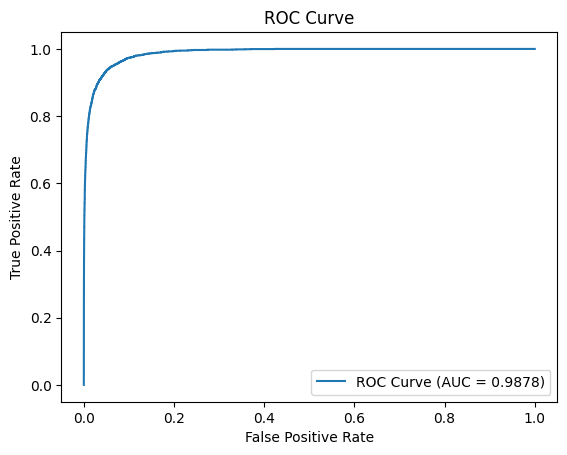

In [39]:
# Calculate AUC-ROC
auc_score = roc_auc_score(y_test, probabilities)

# Evaluate recall at a target FPR
target_fpr = 0.05  # Specify the desired FPR
recall = recall_at_fpr(y_test, probabilities, target_fpr)

# Calculate the full ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Convert FPR, TPR, and Thresholds to a DataFrame
roc_data = pd.DataFrame({
    "False Positive Rate (FPR)": fpr,
    "True Positive Rate (TPR)": tpr,
    "Threshold": thresholds
})

# Display all the results
print(roc_data)

roc_data.to_csv("roc_curve_results.csv", index=False)
print("\nResults saved to 'roc_curve_results.csv'")

# Print key metrics
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Recall at FPR {target_fpr * 100:.1f}%: {recall:.2f}")

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.4f})".format(auc_score))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


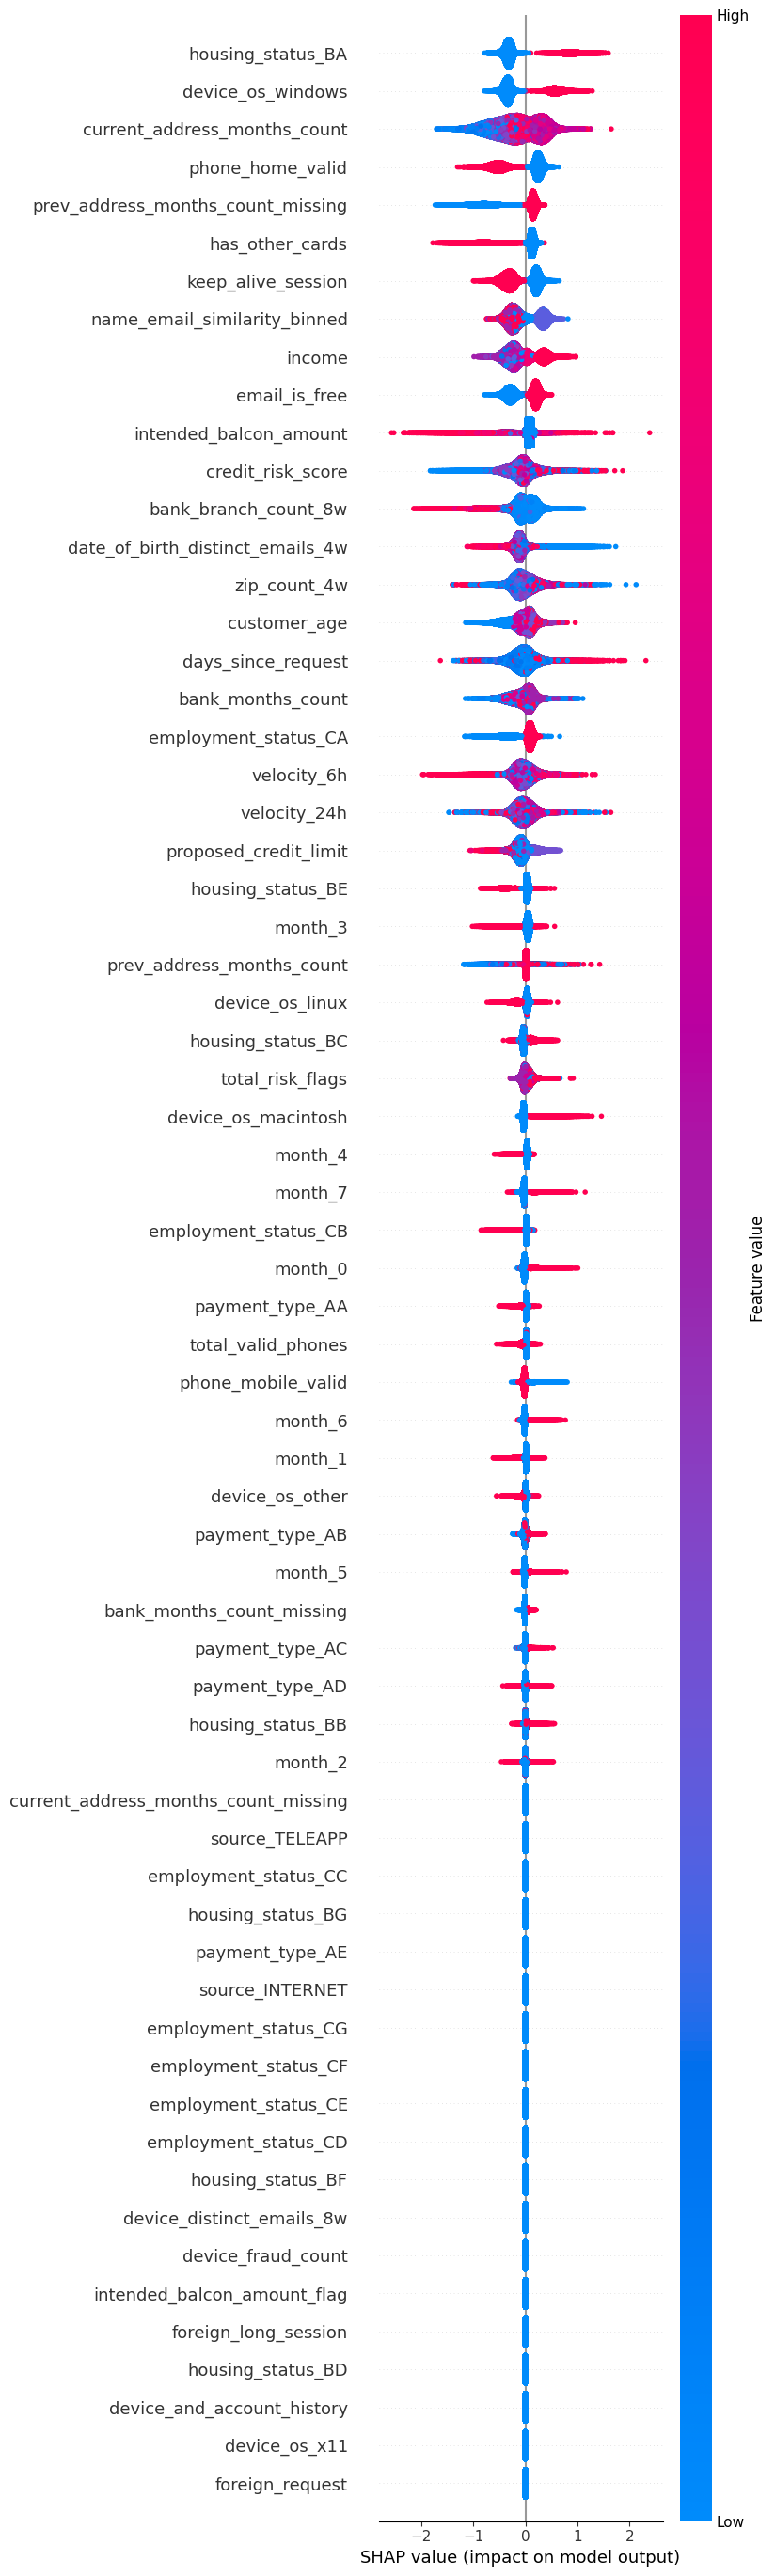

SHAP Summary Plot URL: iVBORw0KGgoAAAANSUhEUgAAAyAAAAq+CAYAAABphDSIAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/GU6VOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3gUVfvw8e9syaZXQggt9A5SgggCooAgJKg0UVFEBaTZAPuroPizPFhAuoUqShENIYCiEBRQuoCC9NCSENL7Zsu8fyxZsmwICaQB9+e6otnZM2fOzM6Gc89piqqqKkIIIYQQQghRDjQVXQAhhBBCCCHE7UMCECGEEEIIIUS5kQBECCGEEEIIUW4kABFCCCGEEEKUGwlAhBBCCCGEEOVGAhAhhBBCCCFEuZEARAghhBBCCFFuJAARQgghhBBClBsJQIQQQgghhBDlRgIQIYQQQgghRLmRAEQIIYQQQghRbiQAEUIIIYQQQpQbCUCEEEIIIYQQ5UYCECGEEEIIIUS5kQBECCGEEEKI28jkyZPx9PS85nsxMTEoisKqVatKlP+19tOVrLhCCCGEEEKI20FwcDB//vknjRo1KtV8JQARQgghhBBCODEYDNx1112lnq90wRJCCCGEEEI4KawrVV5eHs8//zz+/v74+voyatQoli1bhqIoxMTEOOyfm5vLuHHj8PPzIzg4mIkTJ2I2myUAEUIIIYQQ4nZkNpudfqxWa5H7vPbaa8ybN49XX32V5cuXY7Vaee211wpN++abb6LRaFixYgXPPfccn3zyCV999ZV0wRJCCCGEEOJ2k5WVhV6vL/Q9Dw+PQrcnJyczZ84c3nrrLV599VUAevXqRY8ePTh79qxT+g4dOjBjxgwAevbsyebNm1m1apUEIEIIIYS4eZlMJhYsWADA8OHDr1qhEqJcKf0rugQ26uqrvuXm5sbvv//utH3+/PksW7as0H0OHjxIbm4u/

In [45]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import io
import base64

def generate_shap_summary_plot(model, processed_input, max_features=20):
    """
    Generates a SHAP summary plot for the given model and input data.

    Parameters:
        model: Trained model (e.g., XGBoostClassifier).
        processed_input: Preprocessed input data (after transformations).
        max_features: Maximum number of features to display in the plot.

    Returns:
        shap_plot_url: Base64-encoded URL of the SHAP summary plot.
        shap_df: DataFrame containing SHAP values with feature names.
    """
    # Initialize SHAP TreeExplainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(processed_input)

    # Handle binary classification SHAP values
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Take SHAP values for the positive class

    # Create SHAP summary plot
    plt.figure()
    shap.summary_plot(shap_values, processed_input, max_display=max_features, show=False)

    # Save the plot as a base64 string
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    shap_plot_url = base64.b64encode(buf.getvalue()).decode("utf8")
    buf.close()
    plt.show()  # Ensure the plot is displayed when running as a script
    plt.close()  # Close the figure to free resources

    # Convert SHAP values to DataFrame for debugging
    shap_df = pd.DataFrame(shap_values, columns=processed_input.columns)

    return shap_plot_url, shap_df

# Generate the SHAP plot and display
shap_plot_url, shap_df = generate_shap_summary_plot(loaded_model, X_test_preprocessed, max_features=65)
print("SHAP Summary Plot URL:", shap_plot_url)
print("SHAP DataFrame:\n", shap_df.head())


Threshold at 5% FPR: 0.0340
Precision at 5% FPR: 0.1732
Recall at 5% FPR: 0.9356


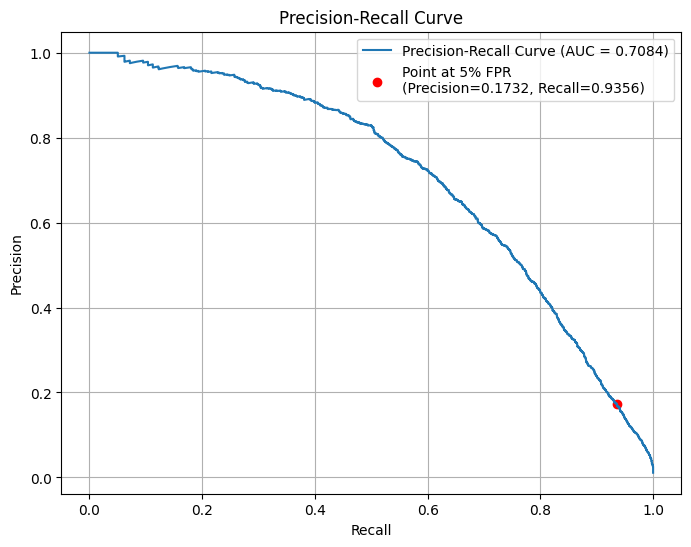

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_score, recall_score, precision_recall_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, probabilities)

# Find the threshold for FPR = 5%
target_fpr = 0.05
idx = np.where(fpr <= target_fpr)[0][-1]  # Last index where FPR <= 5%
threshold_at_5_fpr = thresholds_roc[idx]

# Calculate predictions at the threshold for FPR = 5%
y_pred_at_5_fpr = (probabilities >= threshold_at_5_fpr).astype(int)

# Calculate Precision and Recall at 5% FPR
precision_at_5_fpr = precision_score(y_test, y_pred_at_5_fpr)
recall_at_5_fpr = recall_score(y_test, y_pred_at_5_fpr)

print(f"Threshold at 5% FPR: {threshold_at_5_fpr:.4f}")
print(f"Precision at 5% FPR: {precision_at_5_fpr:.4f}")
print(f"Recall at 5% FPR: {recall_at_5_fpr:.4f}")

# Calculate Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, probabilities)

# Calculate AUC for Precision-Recall Curve
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Precision-Recall Curve (AUC = {pr_auc:.4f})")
plt.scatter([recall_at_5_fpr], [precision_at_5_fpr], color="red", label=f"Point at 5% FPR\n(Precision={precision_at_5_fpr:.4f}, Recall={recall_at_5_fpr:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()


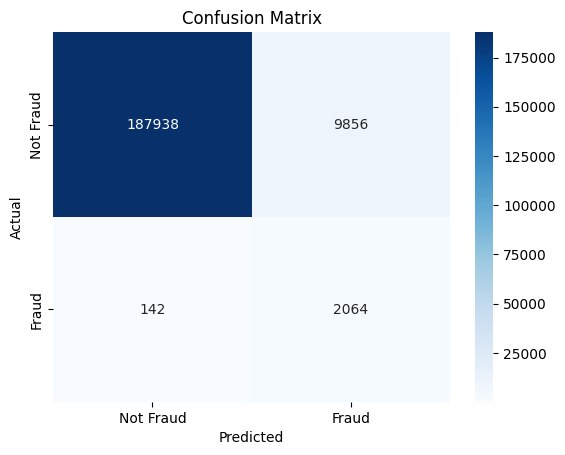

In [56]:
# Generate predictions
predictions = loaded_model.predict(X_test_preprocessed)

threshold_at_fpr_5 = thresholds[np.where(fpr <= 0.05)[0][-1]]
predictions = (probabilities >= threshold_at_fpr_5).astype(int)


# Compute Confusion Matrix
cm = confusion_matrix(y_test, predictions)
labels = ["Not Fraud", "Fraud"]

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97    197794
           1       0.17      0.94      0.29      2206

    accuracy                           0.95    200000
   macro avg       0.59      0.94      0.63    200000
weighted avg       0.99      0.95      0.97    200000

